Advanced Lane Finding Project
The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

from IPython.core.debugger import set_trace


In [2]:
def getCameraCalibrationCoefficients():
    objP = np.zeros((6 * 9, 3), np.float32)
    objP[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # mgrid: returns a dense multi-dimensional "meshgrid"

    objPoints = []
    imgPoints = []

    images = glob.glob("./camera_cal/calibration*.jpg")
    imgSize = (0, 0)
    for fname in images:
        img = cv2.imread(fname)
        imgSize = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            objPoints.append(objP)
            imgPoints.append(corners)

            img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
#             plt.imshow(img)
            
    ret, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imgSize, None, None)

    return ret, matrix, distortion, rvecs, tvecs
#         cv2.waitKey(500)
        
# cv2.destoryAllWindows()
ret, matrix, distortion, rvecs, tvecs = getCameraCalibrationCoefficients()


In [3]:
# pass (height, width) to calibrateCamera()

# matrix is camera matrix
# distortion is distortion coefficients
def undistortImage(img, matrix, distortion):

    dst = cv2.undistort(img, matrix, distortion, None, matrix)

    return dst

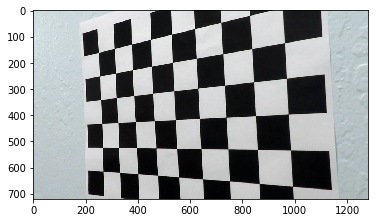

In [4]:
test_distort_image = cv2.imread('./camera_cal/calibration4.jpg')
undistortImg = undistortImage(test_distort_image, matrix, distortion)
plt.figure()
plt.imshow(undistortImg)

In [5]:
def warpImage(img, srcPoints, dstPoints):
    imageSize = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    Minverse = cv2.getPerspectiveTransform(dstPoints, srcPoints)
    
    warped_image = cv2.warpPerspective(img, M, imageSize, flags=cv2.INTER_LINEAR)
    
    return warped_image, M, Minverse
    

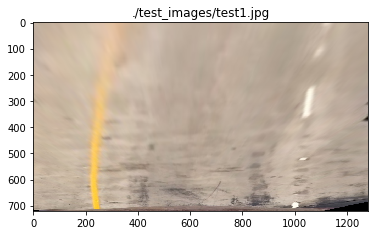

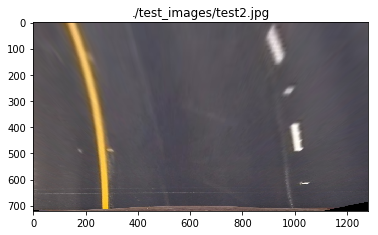

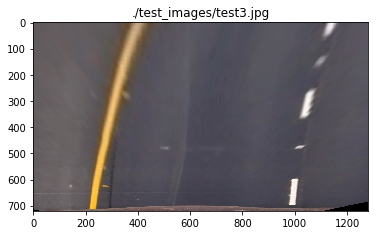

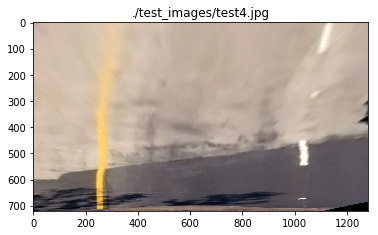

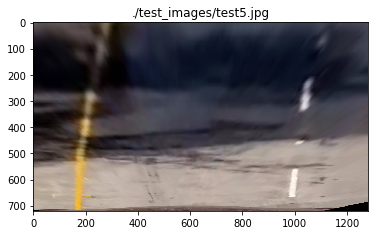

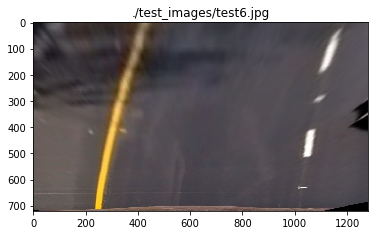

In [6]:
def testWarpImage():
    imageNames = glob.glob("./test_images/test*.jpg")    
    for imageName in imageNames:
        test_distort_image = cv2.imread(imageName)
        test_undistort_image = undistortImage(test_distort_image, matrix, distortion)

        src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
        dst = np.float32([[200, 0], [950, 0], [950, test_undistort_image.shape[0]], [200, test_undistort_image.shape[0]]])

        testWarpImage, M, MInverse = warpImage(test_undistort_image, src, dst)
        
        plt.figure()
        plt.imshow(cv2.cvtColor(testWarpImage, cv2.COLOR_BGR2RGB))
        plt.title(imageName)
        
testWarpImage()

In [7]:
def hlsLChannel(img, threshold=(220, 255)):
    hlsImage = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lChannel = hlsImage[:, :, 1]
    lChannel = lChannel * (255 / np.max(lChannel))
    binaryOutput = np.zeros_like(lChannel)
    binaryOutput[(lChannel > threshold[0]) & (lChannel <= threshold[1])] = 1

    return binaryOutput

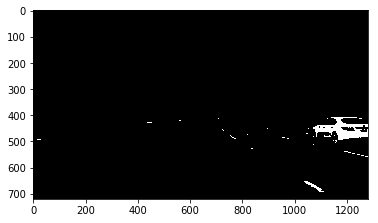

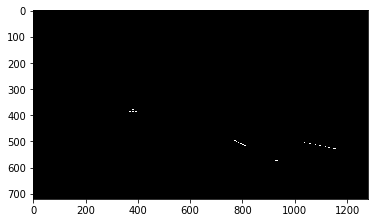

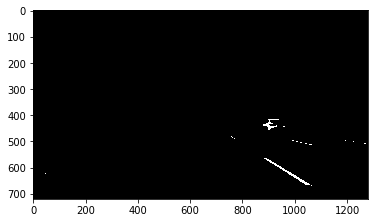

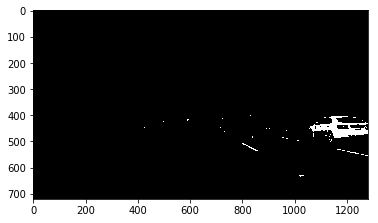

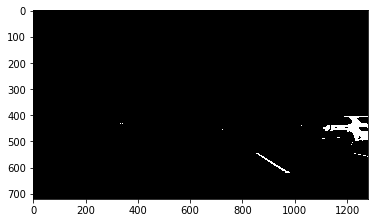

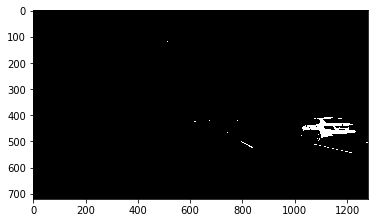

In [8]:
def testHLSLChannel():
    imageNames = glob.glob("./test_images/test*.jpg")    
    for imageName in imageNames:
        test_distort_image = cv2.imread(imageName)
        test_undistort_image = undistortImage(test_distort_image, matrix, distortion)

        lChannelImage = hlsLChannel(test_undistort_image)

        plt.figure()
        plt.imshow(lChannelImage, cmap='gray')
        
testHLSLChannel()

In [9]:
def hlsSChannel(img, threshold=(125, 255)):
    hlsImage = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    sChannel = hlsImage[:, :, 2]
    sChannel = sChannel * (255 / np.max(sChannel))
    binaryOutput = np.zeros_like(sChannel)
    binaryOutput[(sChannel > threshold[0]) & (sChannel <= threshold[1])] = 1
    
    return binaryOutput


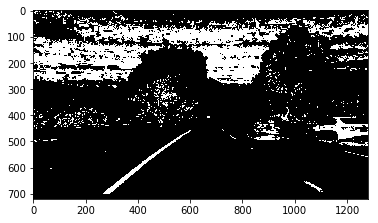

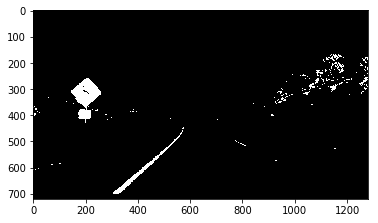

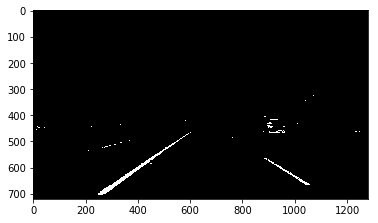

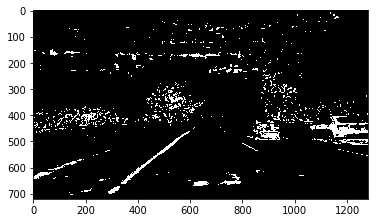

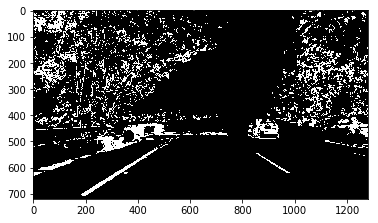

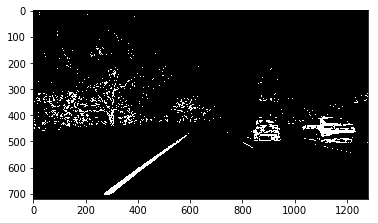

In [10]:
def testHLSSChannel():
    imageNames = glob.glob("./test_images/test*.jpg")    
    for imageName in imageNames:
        test_distort_image = cv2.imread(imageName)
        test_undistort_image = undistortImage(test_distort_image, matrix, distortion)

        sChannelImage = hlsSChannel(test_undistort_image)

        plt.figure()
        plt.imshow(sChannelImage, cmap='gray')
        
testHLSSChannel()

In [11]:
def directionThreshold(img, sobel_kernel=3, threshold=(0, np.pi / 2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absSobelX = np.absoulte(sobelX)
    absSobelY = np.absoulte(sobelY)
    
    directionSobelXY = np.arctan2(absSobelY, absSobelX)
    
    bianryOutput = np.zeros_like(directionSobelXY)
    binaryOutput[(directionSobelXY >= threshold[0]) & (directionSobelXY <= threshold[1])] = 1
    
    return binaryOutput


In [12]:
def magnitudeThreshold(img, sobel_kernel=3, threshold=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitudeSobelXY = np.sqrt(sobelX ** 2, sobelY ** 2)
    scaledSobelXY = np.uint8(magnitudeSobelXY / np.max(magnitudeSobelXY) * 255)
    
    binaryOutput = np.zeros_like(scaledSobelXY)
    binaryOutput[(scaledSobelXY >= threshold[0]) & (scaledSobelXY <= threshold[1])] = 1
    
    return binaryOutput


In [13]:
def absSobelThreshold(img, orient='x', threshold_min=0, threshold_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
    if orient == 'x':
        absSobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    if orient == 'y':
        absSobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaledSobel = np.uint8(absSobel / np.max(absSobel) * 255)
    
    binaryOutput = np.zeros_like(absSobel)
    binaryOutput[(scaledSobel >= threshold_min) & (scaledSobel <= threshold_max)] = 1
    
    return binaryOutput


In [14]:
def labBChannel(img, threshold=(215, 255)):
    labImage = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    bChannel = labImage[:, :, 2]
    
    if np.max(bChannel) > 100:
        bChannel = bChannel * (255 / np.max(bChannel))
        
    binaryOutput = np.ones_like(bChannel)
    binaryOutput[(bChannel >= threshold[0]) & (bChannel <= threshold[1])] = 0
    
    return binaryOutput


In [15]:
def combineBinary(img, sobelBinary):
    lBinary = hlsLChannel(img)
    bBinary = labBChannel(img)
    
    combineBinary = np.zeros_like(sobelBinary)
    
    combineBinary[(lBinary == 1) | (bBinary == 0)] = 1
    
    return combineBinary

# plt.figure()
# plt.imshow(testWarpImage)

# combinedBinary = combineBinary(testWarpImage, absSobelThreshold(testWarpImage, 'x', threshold_min=40, threshold_max=100))
# plt.figure()
# plt.imshow(combinedBinary, cmap='gray')


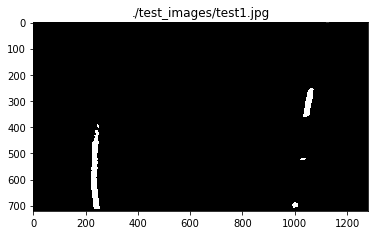

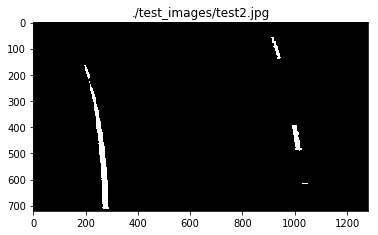

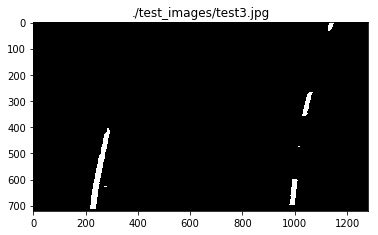

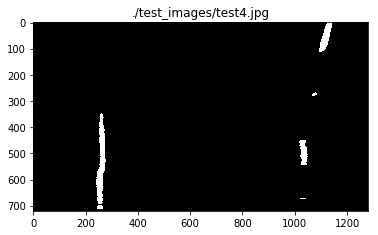

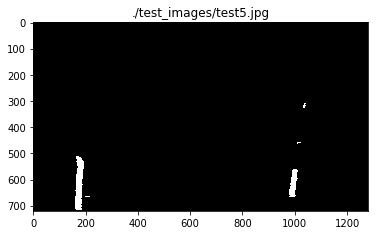

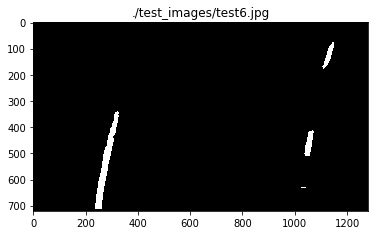

In [16]:
def testBinary():
    imageNames = glob.glob("./test_images/test*.jpg")    
    for imageName in imageNames:
        test_distort_image = cv2.imread(imageName)
        test_undistort_image = undistortImage(test_distort_image, matrix, distortion)

        src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
        dst = np.float32([[200, 0], [950, 0], [950, test_undistort_image.shape[0]], [200, test_undistort_image.shape[0]]])

        testWarpImage, M, MInverse = warpImage(test_undistort_image, src, dst)
        combinedBinary = combineBinary(testWarpImage, absSobelThreshold(testWarpImage, 'x', threshold_min=40, threshold_max=100))
        plt.figure()
        plt.imshow(combinedBinary, cmap='gray')
#         plt.figure()
#         plt.imshow(cv2.cvtColor(testWarpImage, cv2.COLOR_BGR2RGB))
        plt.title(imageName)
        
testBinary()

In [17]:
def findLanePixels(binaryWarped, nwindows, margin, minpix):
    histogram = np.sum(binaryWarped[binaryWarped.shape[0] // 2:, :], axis=0)
    outImage = np.dstack((binaryWarped, binaryWarped, binaryWarped))
#     print(outImage)
    
    midPoint = np.int(histogram.shape[0] // 2)
    
    leftXBase = np.argmax(histogram[:midPoint])
    rightXBase = np.argmax(histogram[midPoint:]) + midPoint
    
    windowHeight = np.int(binaryWarped.shape[0] // nwindows)
    
    nonzero = binaryWarped.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])
    
    leftXCurrent = leftXBase
    rightXCurrent = rightXBase
    
    leftLaneInds = []
    rightLaneInds = []
    
    for window in range(nwindows):
        
        windowYLow = binaryWarped.shape[0] - (window + 1) * windowHeight
        windowYHigh = binaryWarped.shape[0] - window * windowHeight
        windowXLeftLow = leftXCurrent - margin
        windowXLeftHigh = leftXCurrent + margin
        windowXRightLow = rightXCurrent - margin
        windowXRightHigh = rightXCurrent + margin

        cv2.rectangle(outImage, (windowXLeftLow, windowYLow), (windowXLeftHigh, windowYHigh), (0, 255, 0), 2)
        cv2.rectangle(outImage, (windowXRightLow, windowYLow), (windowXRightHigh, windowYHigh), (0, 255, 0), 2)
 
        goodLeftInds = ((nonzeroY >= windowYLow) & (nonzeroY < windowYHigh) & 
                        (nonzeroX >= windowXLeftLow) & (nonzeroX < windowXLeftHigh)).nonzero()[0]
        goodRightInds = ((nonzeroY >= windowYLow) & (nonzeroY < windowYHigh) &
                         (nonzeroX >= windowXRightLow) & (nonzeroX < windowXRightHigh)).nonzero()[0]
        
        leftLaneInds.append(goodLeftInds)
        rightLaneInds.append(goodRightInds)
  
        if len(goodLeftInds) > minpix:
            leftXCurrent = np.int(np.mean(nonzeroX[goodLeftInds]))
        if len(goodRightInds) > minpix:
            rightXCurrent = np.int(np.mean(nonzeroX[goodRightInds]))
            
    try:
        leftLaneInds = np.concatenate(leftLaneInds)
        rightLaneInds = np.concatenate(rightLaneInds)
    except ValueError:
        pass

    leftX = nonzeroX[leftLaneInds]
    leftY = nonzeroY[leftLaneInds]
    rightX = nonzeroX[rightLaneInds]
    rightY = nonzeroY[rightLaneInds]
    
    return leftX, leftY, rightX, rightY, outImage


In [18]:
def fitPolynomial(binaryWarped, nwindows=9, margin=100, minpix=50):
    leftX, leftY, rightX, rightY, outImage = findLanePixels(binaryWarped, nwindows, margin, minpix)

    leftFit = np.polyfit(leftY, leftX, 2)
    rightFit = np.polyfit(rightY, rightX, 2)
    
    plotY = np.linspace(0, binaryWarped.shape[0] - 1, binaryWarped.shape[0])
    
    try:
        leftFitX = leftFit[0] * (plotY ** 2) + leftFit[1] * plotY + leftFit[2]
        rightFitX = rightFit[0] * (plotY ** 2) + rightFit[1] * plotY + rightFit[2]
 
    except TypeError:
        print('The function failed to fit a line')
        leftFitX = 1 * plotY ** 2 + 1 * plotY
        rightFitX = 1 * plotY ** 2 + 1 * plotY

    outImage[leftY, leftX] = [255, 0, 0]
    outImage[rightY, rightX] = [0, 0, 255]
    
    return outImage, leftFit, rightFit, plotY
    

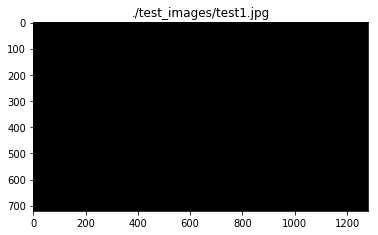

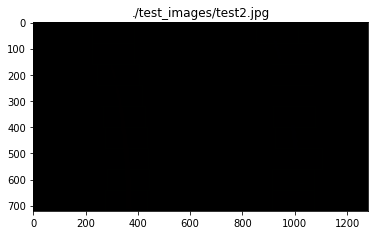

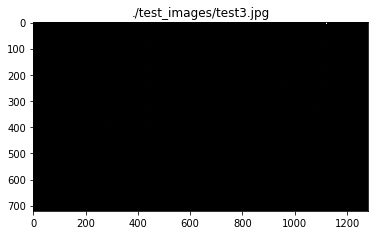

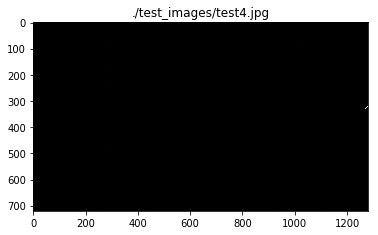

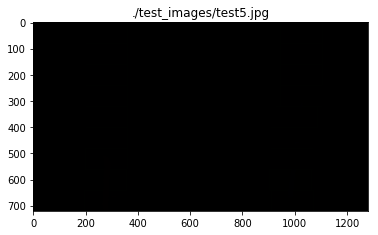

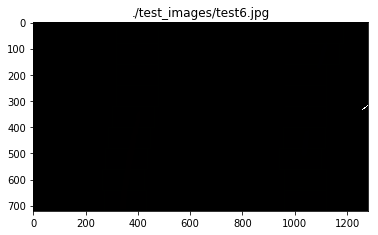

In [19]:
def testFitPolynomial():
    imageNames = glob.glob("./test_images/test*.jpg")    
    for imageName in imageNames:
        test_distort_image = cv2.imread(imageName)
        test_undistort_image = undistortImage(test_distort_image, matrix, distortion)

        src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
        dst = np.float32([[300, 0], [950, 0], [950, test_undistort_image.shape[0]], [300, test_undistort_image.shape[0]]])

        testWarpImage, M, MInverse = warpImage(test_undistort_image, src, dst)
        combinedBinary = combineBinary(testWarpImage, absSobelThreshold(testWarpImage, 'x', threshold_min=40, threshold_max=100))
        outImage, leftFit, rightFit, plotY = fitPolynomial(combinedBinary, nwindows=9, margin=80, minpix=40)

        plt.figure()
        plt.imshow(outImage)
#         plt.imshow(cv2.cvtColor(outImage, cv2.COLOR_BGR2RGB))
        plt.title(imageName)
        
testFitPolynomial()

In [20]:
def fitPoly(imgShape, leftX, leftY, rightX, rightY):
    leftFit = np.polyfit(leftY, leftX, 2)
    rightFit = np.polyfit(rightY, rightX, 2)
    plotY = np.linspace(0, imgShape[0] - 1, imgShape[0])
    
    leftFitX = leftFit[0] * (plotY ** 2) + leftFit[1] * plotY + leftFit[2]
    rightFitX = rightFit[0] * (plotY ** 2) + rightFit[1] * plotY + rightFit[2]
    
    return leftFitX, rightFitX, plotY, leftFit, rightFit


In [21]:

def searchAroundPoly(binaryWarped, leftFit, rightFit):
    margin = 100
    
    nonzeros = binaryWarped.nonzero()
    nonzeroY = np.array(nonzeros[0])
    nonzeroX = np.array(nonzeros[1])
    
    # find indices of left and right lanes
    leftLaneLeft = leftFit[0] * (nonzeroY ** 2) + leftFit[1] * nonzeroY + leftFit[2] - margin
    leftLaneRight = leftFit[0] * (nonzeroY ** 2) + leftFit[1] * nonzeroY + leftFit[2] + margin
    rightLaneLeft = rightFit[0] * (nonzeroY ** 2) + rightFit[1] * nonzeroY + rightFit[2] - margin
    rightLaneRight = rightFit[0] * (nonzeroY ** 2) + rightFit[1] * nonzeroY + rightFit[2] + margin
    
    leftLaneInds = ((nonzeroX > leftLaneLeft) & (nonzeroX < leftLaneRight))
    rightLaneInds = ((nonzeroX > rightLaneLeft) & (nonzeroX < rightLaneRight))

    # extract left and right lane pixel poisitions
    
    leftX = nonzeroX[leftLaneInds]
    leftY = nonzeroY[leftLaneInds]
    rightX = nonzeroX[rightLaneInds]
    rightY = nonzeroY[rightLaneInds]

    # fit new polynomials
    
    leftFitX, rightFitX, plotY, leftFit, rightFit = fitPoly(binaryWarped.shape, leftX, leftY, rightX, rightY)
    
    # visulization
    # 1. create a new image
    outImage = np.dstack((binaryWarped, binaryWarped, binaryWarped))
    windowImage = np.zeros_like(outImage)
    
    # 2. color pixels of lanes
    
    outImage[leftY, leftX] = [255, 0, 0]
    outImage[rightY, rightX] = [0, 0, 255]
    
    # 3. genearte a polygon to illustrate the search window area
    
    leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitX - margin, plotY]))])
    leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitX + margin, plotY])))])
    leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
    
    rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitX - margin, plotY]))])
    rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitX + margin, plotY])))])
    rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
    
    # 4. recast the x and y points into usable format for cv2.fillPoly()
    
    cv2.fillPoly(windowImage, np.int_([leftLinePts]), (0, 255, 0))
    cv2.fillPoly(windowImage, np.int_([rightLinePts]), (0, 255, 0))
    result = cv2.addWeighted(outImage, 1, windowImage, 0.3, 0)
        
    return result, leftFit, rightFit, plotY
#     draw the lane onto the warped blank image
    
    

In [22]:
# plt.figure()
# plt.imshow(combinedBinary)

# track_result, track_left_fit, track_right_fit, ploty, = searchAroundPoly(combinedBinary, leftFit, rightFit)
# plt.figure()
# plt.imshow(track_result)

In [23]:
def measureCurvatureReal(leftFitCurve, rightFitCurve, plotY, ymPerPix=30 / 720, xmPerPix=3.7 / 700):
    yEval = np.max(plotY)
    
    leftCurveRad = ((1 + (2 * leftFitCurve[0] * yEval * ymPerPix + leftFitCurve[1]) ** 2) ** 1.5) / np.absolute(2 * leftFitCurve[0])
    rightCurveRad = ((1 + (2 * rightFitCurve[0] * yEval * ymPerPix + rightFitCurve[1]) ** 2) ** 1.5) / np.absolute(2 * rightFitCurve[0])
    
    leftPosition = leftFitCurve[0] * 720 + leftFitCurve[1] * 720 + leftFitCurve[2]
    rightPosition = rightFitCurve[0] * 720 + rightFitCurve[1] * 720 + rightFitCurve[2]
    
    midPoint = 1280 / 2
    
    laneCenter = (leftPosition + rightPosition) / 2
    offset = (midPoint - laneCenter) * xmPerPix
    
    return leftCurveRad, rightCurveRad, offset


In [24]:
# leftCurveRad, rightCurveRad, offset = measureCurvatureReal(track_left_fit, track_right_fit, ploty)
# averageCurveRad = (leftCurveRad + rightCurveRad)/2
# print(leftCurveRad, 'm', rightCurveRad, 'm', averageCurveRad, 'm')
# print('offset : ', offset, 'm')

In [25]:
def drawing(undistortion, binaryWarped, colorWarped, MInverse, leftFitX, rightFitX, plotY):
    warpZero = np.zeros_like(binaryWarped).astype(np.uint8)
    colorWarp = np.dstack((warpZero, warpZero, warpZero))
    
    ptsLeft = np.array([np.transpose(np.vstack([leftFitX, plotY]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitX, plotY])))])
    pts = np.hstack((ptsLeft, ptsRight))
    
    cv2.fillPoly(colorWarped, np.int_([pts]), (0, 255, 0))
    
    newWarp = cv2.warpPerspective(colorWarped, MInverse, (undistortion.shape[1], undistortion.shape[0]))
    
    result = cv2.addWeighted(undistortion, 1, newWarp, 0.3, 0)
    
    return result

def drawText(image, curveRad, offset):
    result = np.copy(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve Radius: ' + '{:04.2f}'.format(curveRad) + 'm'
    cv2.putText(result, text, (20, 50), font, 1.2, (255, 255, 255), 2)
    
    if offset > 0:
        text = 'right of center : ' + '{:04.3f}'.format(abs(offset)) + 'm '
    else:
        text = 'left  of center : ' + '{:04.3f}'.format(abs(offset)) + 'm '
    cv2.putText(result, text, (20, 100), font, 1.2, (255, 255, 255), 2)
    
    return result

In [26]:
# leftFitX = track_left_fit[0] * (ploty ** 2) + track_left_fit[1] * (ploty ** 2) + track_left_fit[2]
# rightFitX = track_right_fit[0] * (ploty ** 2) + track_right_fit[1] * (ploty ** 2) + track_right_fit[2]

# result = drawing(test_undistort_image, combinedBinary, testWarpImage, MInverse, leftFitX, rightFitX)
# textResult = drawText(result, averageCurveRad, offset)
# plt.figure()
# plt.imshow(cv2.cvtColor(textResult, cv2.COLOR_BGR2RGB))


In [27]:
def pipeline(image):
    # 1. get camera calibration matrix and coefficients
    ret, matrix, distortion, rvecs, tvecs = getCameraCalibrationCoefficients()
    
    # 2. undistort image
    undistortedImage = undistortImage(image, matrix, distortion)
    
    # 3. image perspective trransformation
    src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
    dst = np.float32([[300, 0], [950, 0], [950, undistortedImage.shape[0]], [300, undistortedImage.shape[0]]])

    warpedImage, M, MInverse = warpImage(undistortedImage, src, dst)
    
    # 4. color threshold and gradients    
    combinedBinary = combineBinary(warpedImage, absSobelThreshold(warpedImage, 'x', threshold_min=40, threshold_max=100))
    
    # 5. sliding window
    outImage, leftFit, rightFit, plotY = fitPolynomial(combinedBinary, nwindows=9, margin=80, minpix=40)
    
    # 6. Tracking
    trackResult, trackLeftFit, trackRightFit, plotY = searchAroundPoly(combinedBinary, leftFit, rightFit)
    
    # 7. measure curvatures
    leftCurveRad, rightCurveRad, offset = measureCurvatureReal(trackLeftFit, trackRightFit, plotY)
    averageCurveRad = (leftCurveRad + rightCurveRad) / 2
    
    # 8. drawing
    leftFitX = trackLeftFit[0] * (plotY ** 2) + trackLeftFit[1] * (plotY ** 2) + trackLeftFit[2]
    rightFitX = trackRightFit[0] * (plotY ** 2) + trackRightFit[1] * (plotY ** 2) + trackRightFit[2]

    result = drawing(undistortedImage, combinedBinary, warpedImage, MInverse, leftFitX, rightFitX, plotY)
    textResult = drawText(result, averageCurveRad, offset)
    
    return textResult


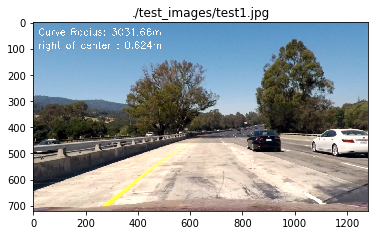

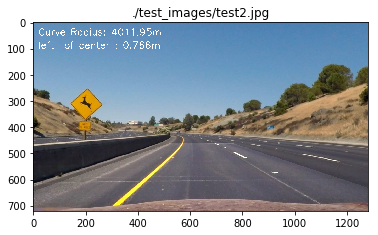

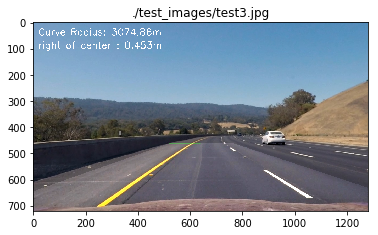

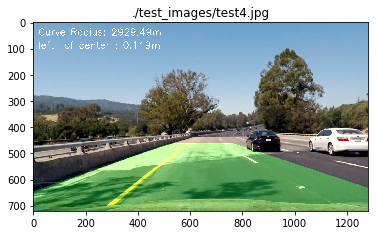

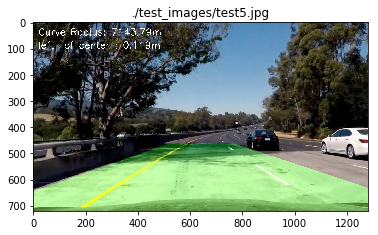

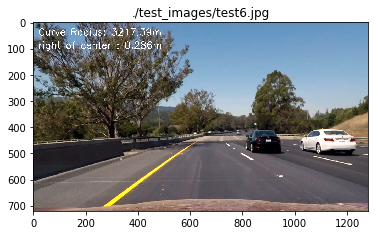

In [28]:
def testPipeline():
    imageNames = glob.glob("./test_images/test*.jpg")    
    for imageName in imageNames:
        image = cv2.imread(imageName)
        result = pipeline(image)
        
        plt.figure()
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(imageName)

testPipeline()